## Viscoplastic material

Small example, how to create a material model with viscoplastic properties. Formulation is done in context of small strains

In [1]:
using ForwardDiff
using PyPlot

In [2]:

"""
Hooke isotropic stiffness tensor
"""
function hookeStiffnessTensor(E, ν)
    a = 1 - ν
    b = 1 - 2*ν
    c = 1 + ν
    multiplier = E / (b * c)
    return Float64[a ν ν 0 0 0;
                   ν a ν 0 0 0;
                   ν ν a 0 0 0;
                   0 0 0 b 0 0;
                   0 0 0 0 b 0;
                   0 0 0 0 0 b].*multiplier
end

# Pick material values
E = 152.0e3
ν =  0.3
C = hookeStiffnessTensor(E, ν)

6x6 Array{Float64,2}:
     2.04615e5  87692.3        87692.3        0.0        0.0        0.0      
 87692.3            2.04615e5  87692.3        0.0        0.0        0.0      
 87692.3        87692.3            2.04615e5  0.0        0.0        0.0      
     0.0            0.0            0.0        1.16923e5  0.0        0.0      
     0.0            0.0            0.0        0.0        1.16923e5  0.0      
     0.0            0.0            0.0        0.0        0.0        1.16923e5

In [39]:
# Equations can be found from: http://mms2.ensmp.fr/msi_paris/transparents/Georges_Cailletaud/2013-GC-plas3D.pdf

"""
J2 plasticity
"""
function J(σ)
    e1 = (σ[1] - σ[2])^2
    e2 = (σ[2] - σ[3])^2
    e3 = (σ[3] - σ[1])^2
    e4 = σ[4]^2 
    e5 = σ[5]^2
    e6 = σ[6]^2
    return sqrt((e1 + e2 + e3 + 6 * (e4 + e5 + e6)) / 2.)
end

"""
Yield function
"""
function f(σ, σ_y)
    return J(σ) - σ_y
end

"""
Viscoplastic potential

Parameters
----------
    f_val: float
        Yield function value
    n: float
        Material constant
    K: float
        Material constant
"""
function viscoplastic_potential(f_val, n, K)
    n_1 = n+1
    return K / n_1 * ( f_val./ K) ^ n_1
end

"""
Function for calculating stress
"""
function calculate_stress(σ_old, dϵ, C, dt, σ_y, n, K)
    σ_new = σ_old + C * dϵ * dt
    if f(σ_new, σ_y) > 0
        
        # Viscoplastic potential derivated via ForwardDiff
        visco_wrap(x) = viscoplastic_potential(f(x, σ_y), n, K)
        dϵ_vp = ForwardDiff.gradient(visco_wrap)
        σ_new = σ_old + C * (dϵ - dϵ_vp(σ_new)) * dt
    end
    return σ_new
end

calculate_stress (generic function with 1 method)

In [75]:
steps = 30

ϵ_hist = zeros(6)
max_strain = 0.0001
ϵ_hist[1] = max_strain
ϵ_hist[2] = max_strain*-0.3
ϵ_hist[3] = max_strain*-0.3;

Plotting with three different $dt$

In [78]:
ϵ_tot_1 = zeros(6)
ϵ_tot_2 = zeros(6)
ϵ_tot_3 = zeros(6)

nσ_1 = zeros(6)
nσ_2 = zeros(6)
nσ_3 = zeros(6)

dt_1 = 0.01
dt_2 = 0.1
dt_3 = 0.4

σ_1 = []
σ_2 = []
σ_3 = []

ϵ_1 = []
ϵ_2 = []
ϵ_3 = []

σ_y = 150.0
nn = 0.92
K = 180.0e3

for n=1:steps
    dϵ_1 = ϵ_hist / dt_1
    dϵ_2 = ϵ_hist / dt_2
    dϵ_3 = ϵ_hist / dt_3
    
    nσ_1 = calculate_stress(nσ_1, dϵ_1, C, dt_1, σ_y, nn, K)
    nσ_2 = calculate_stress(nσ_2, dϵ_2, C, dt_2, σ_y, nn, K)
    nσ_3 = calculate_stress(nσ_3, dϵ_3, C, dt_3, σ_y, nn, K)
    
    ϵ_tot_1 += dϵ_1 * dt_1
    ϵ_tot_2 += dϵ_2 * dt_2
    ϵ_tot_3 += dϵ_3 * dt_3
    
    push!(σ_1, nσ_1[1])
    push!(σ_2, nσ_2[1])
    push!(σ_3, nσ_3[1])
    
    push!(ϵ_1, ϵ_tot_1[1])
    push!(ϵ_2, ϵ_tot_2[1])
    push!(ϵ_3, ϵ_tot_3[1])
end

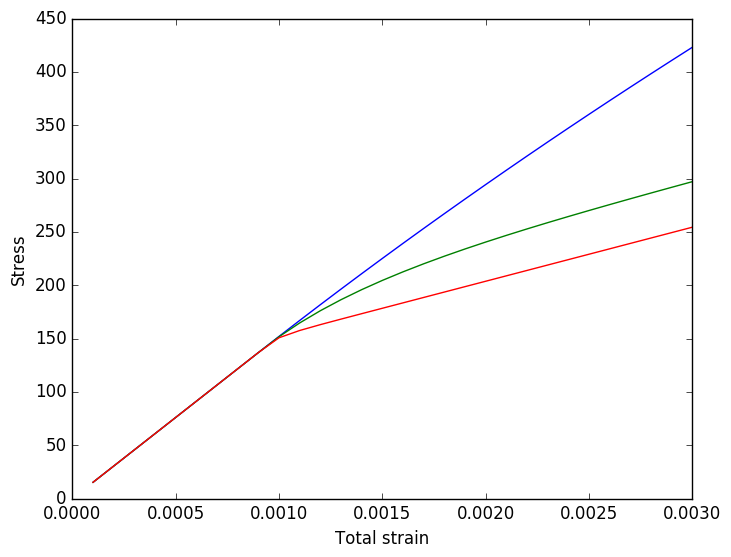

PyObject <matplotlib.text.Text object at 0x7f8692cf6b10>

In [82]:
PyPlot.plot(ϵ_1, σ_1)
PyPlot.plot(ϵ_2, σ_2)
PyPlot.plot(ϵ_1, σ_3)
PyPlot.xlabel("Total strain")
PyPlot.ylabel("Stress")